# Dimensionality Reduction Tutorial

### Bryan Scott, CIERA/Northwestern
version 0.1, August 2023

In this tutorial, we will begin by reading in postage stamp images from the Sloan Digital Sky Survey. The first part of the lesson will then decompose these images into their principle components using both our own implementation of the PCA procedure in numpy, and make use of the scikit-learn PCA implementation. Our learning goals are two fold - to gain familiarity with PCA and to gain experience with scikit-learn on a problem where we can straightforwardly implement our own version of the tools. 

In the second part of the tutorial, we will apply t-SNE to...

In the third part of the tutorial, we will then develop some tools to visualize a pre-trained self-organizing map to study the completements of photometric samples for redshift completeness studies. This is a common and state of the art use case for SOMs within, for example, LSST DESC and for Euclid cosmology. We will use this use case to highlight some limitations of SOMs that arise in practice.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

In [2]:
pwd

'/Users/bryan'

In [3]:
cd Downloads

/Users/bryan/Downloads


## Problem 1: Principal Component Analysis

### Preliminary: Download the images and load them into arrays called images and labels

In [4]:
# To get the images and labels from file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

### Part 0: A Gentle Introduction to the data

The first step in any ML workflow is to 'worry' about the data. First, print out the dimensions of the images and labels arrays. Why does each array have the dimensionality that it does? Write your answer in the provided markdown cell below. 

Now, let's visually inspect our data. In the Wide Field Image Processing session, we have/will cover how to generate false color images from multi-band photometry. For now, we can use the astropy implementation. Given the following help call, fill in the code block below to generate false color images for the first SDSS postage stamp.

In [5]:
from astropy.visualization import make_lupton_rgb

?make_lupton_rgb

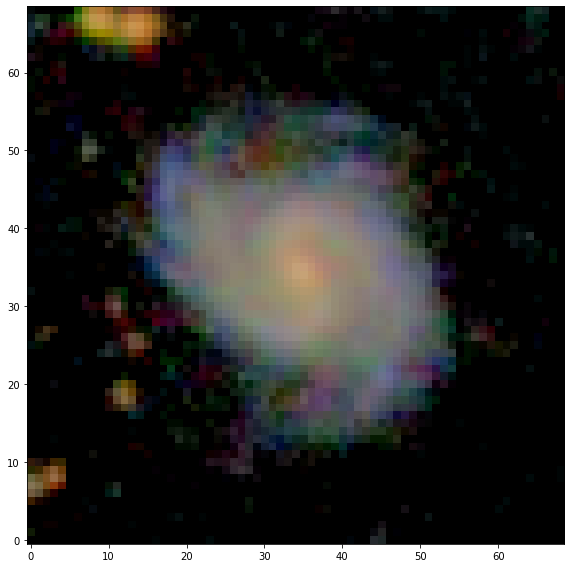

In [6]:
from astropy.visualization import make_lupton_rgb

i_data = images[14001, :, :, 0] # first band
r_data = images[14001, :, :, 1] # second band
g_data = images[14001, :, :, 2] # third band

rgb = make_lupton_rgb((i_data - np.nanmedian(i_data)), # fill this in - what band goes here?
                      (r_data - np.nanmedian(r_data)), # fill this in - what band goes here?
                      (g_data - np.nanmedian(g_data)), # fill this in - and finally what band goes here?
                      minimum=0, Q=6, stretch=50) # Bonus Q: how does changing these paramters change the images?

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin='lower')
fig.tight_layout()

### Visualize individual classes 

The Galaxy10 dataset consists of the following classes: 

Galaxy10 dataset (21785 images)
- Class 0 (3461 images): Disk, Face-on, No Spiral
- Class 1 (6997 images): Smooth, Completely round
- Class 2 (6292 images): Smooth, in-between round
- Class 3 (394 images): Smooth, Cigar shaped
- Class 4 (1534 images): Disk, Edge-on, Rounded Bulge
- Class 5 (17 images): Disk, Edge-on, Boxy Bulge
- Class 6 (589 images): Disk, Edge-on, No Bulge
- Class 7 (1121 images): Disk, Face-on, Tight Spiral
- Class 8 (906 images): Disk, Face-on, Medium Spiral
- Class 9 (519 images): Disk, Face-on, Loose Spiral

Before proceeding, what do you notice about these classes. Why is this potentially problematic? 

Now use the labels vector to visualize a member of each class: 

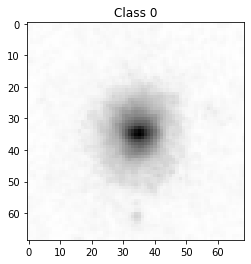

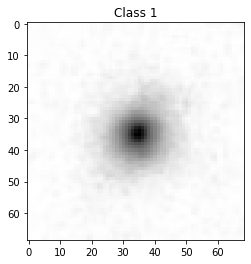

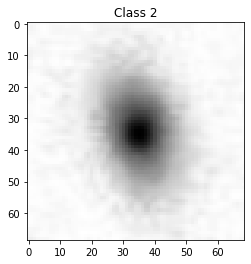

In [7]:
for i in range(0, 3):
    plt.imshow(images[np.where(labels == i)][0, :, :, 0], cmap='Greys')
    plt.title('Class {}'.format(i))
    plt.show()

### Part 1: Principal Components and the Singular Value Decomposition

Can we distinguish galaxy types based on their PCA components? Let's find out! Let's attempt to distinguish between smooth and round objects in Class 1 from the boxy and edge on spirals in Class 4. Start by using the tools you wrote above to visualize an example from each class.

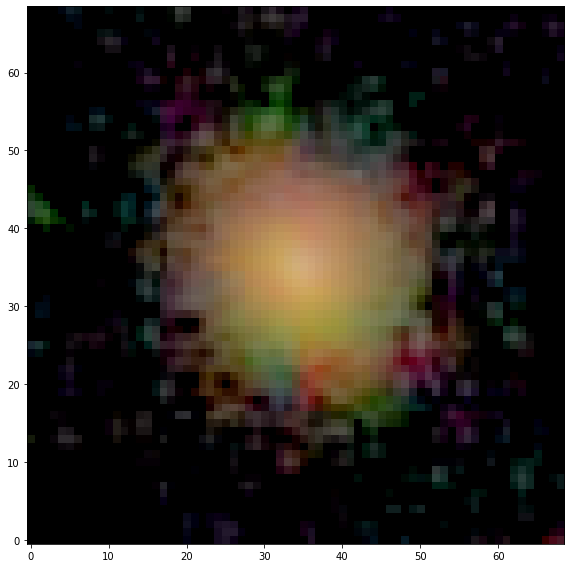

In [8]:
i_data = images[np.where(labels == 1)][0, :, :, 0] # first band
r_data = images[np.where(labels == 1)][0, :, :, 1] # second band
g_data = images[np.where(labels == 1)][0, :, :, 2] # third band

rgb = make_lupton_rgb((i_data - np.nanmedian(i_data)), # fill this in - what band goes here?
                      (r_data - np.nanmedian(r_data)), # fill this in - what band goes here?
                      (g_data - np.nanmedian(g_data)), # fill this in - and finally what band goes here?
                      minimum=0, Q=6, stretch=50) # Bonus Q: how does changing these paramters change the images?

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin='lower')
fig.tight_layout()

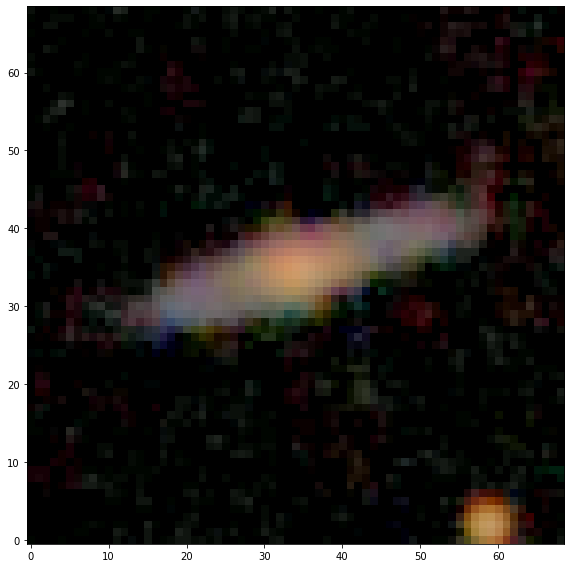

In [9]:
i_data = images[np.where(labels == 4)][10, :, :, 0] # first band
r_data = images[np.where(labels == 4)][10, :, :, 1] # second band
g_data = images[np.where(labels == 4)][10, :, :, 2] # third band

rgb = make_lupton_rgb((i_data - np.nanmedian(i_data)), # fill this in - what band goes here?
                      (r_data - np.nanmedian(r_data)), # fill this in - what band goes here?
                      (g_data - np.nanmedian(g_data)), # fill this in - and finally what band goes here?
                      minimum=0, Q=6, stretch=50) # Bonus Q: how does changing these paramters change the images?

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin='lower')
fig.tight_layout()

Now perform the singular value decomposition using the numpy implementation. 

In [10]:
# first, what does the SVD take as arguments and, in terms of the PCA framework, what does it return? 
# Answer in the provided markdown cell below. 

In [99]:
# Now, you may have noticed that our image array isn't structured in such a way that we can perform PCA 
# on it directly.
# What shape should the image array have, use np.reshape to reshape the array.

images_of_class = images[np.where(labels == 4)][:,:,:,0]#fill this in for the class you want to compute the PCA for
images_of_class_mean_subtracted = (images_of_class - np.mean(images_of_class, axis = 0)) # recenter
images_reshape = images_of_class_mean_subtracted.reshape((np.shape(images_of_class)[0], 69*69)) # what shape should this have?

In [36]:
U, S, Vh = np.linalg.svd(images_reshape, full_matrices=False, compute_uv=True, hermitian=False)

In [37]:
from sklearn.utils.extmath import svd_flip

In [38]:
U, Vh = svd_flip(U, Vh)

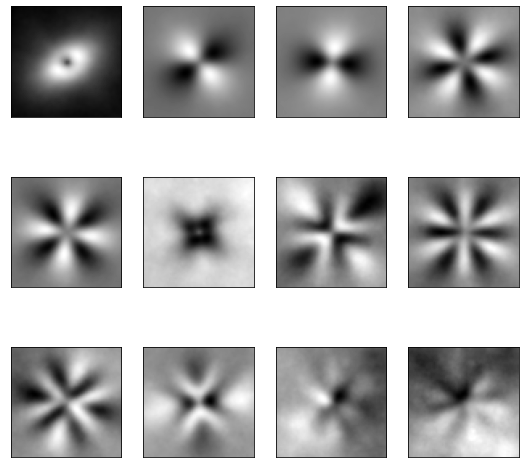

In [39]:
# plot the Principal components

h, w = 69, 69

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(Vh, h, w)

### Part 2: Practicing with the Scikit-learn Implementation

In [40]:
from sklearn.decomposition import PCA

In [53]:
X_train = images_reshape

In [54]:
n_components = 150

print(
    "Extracting the top %d eigengalaxies from %d faces" % (n_components, X_train.shape[0])
)
pca = PCA(n_components=n_components, svd_solver="randomized").fit(X_train)

eigengalaxies = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigengalaxies from 1534 faces


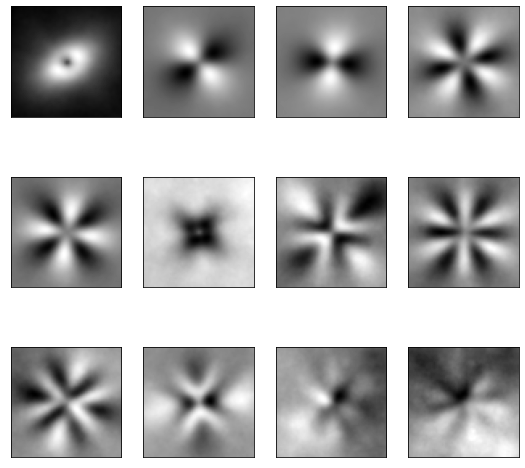

In [55]:
plot_gallery(eigengalaxies, h, w)

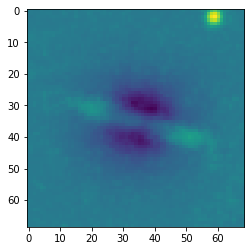

In [98]:
plt.imshow(images_of_class[10])

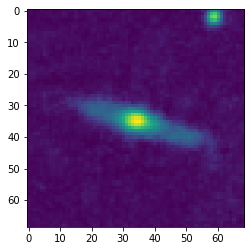

In [97]:
plt.imshow(images[np.where(labels == 4)][10,:,:,0])

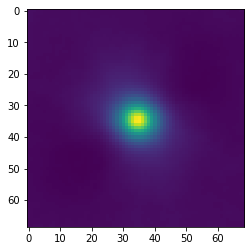

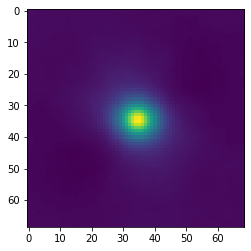

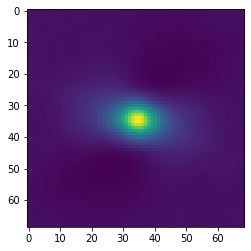

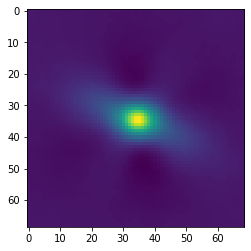

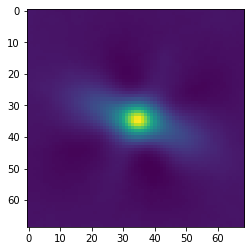

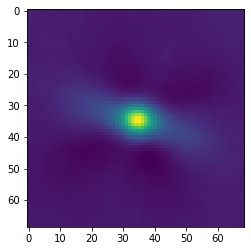

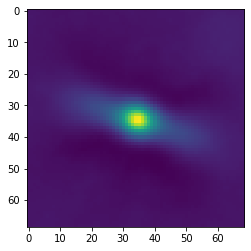

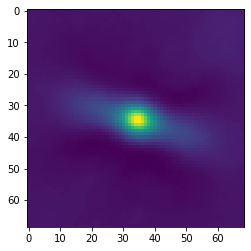

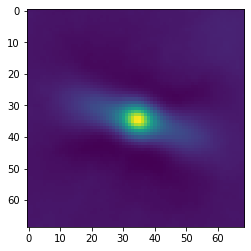

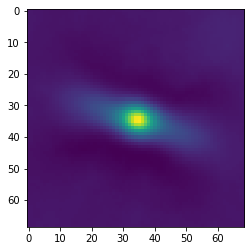

In [108]:
summed = 0
for i in range(0, 10):
    summed += pca.transform(X_train)[10][i]*eigengalaxies[i]
    if i % 1 == 0:
        plt.imshow(summed + np.mean(images_of_class, axis = 0))
        plt.show()

## Problem 2: t-distributed Stochastic Neighbor Embedding

Begin by reading in the supplied cosmos 2020 28 band photometry. Print out the catalog and some summary statistics. Make sure you understand the structure of the supplied data file, and check that it has been cleaned of anamolous values (for example, -99 is often used as a flag value, and many data files contain NaNs). 

In [27]:
cosmos_2020 = pd.read_csv('cosmos_2020_28_band.csv', index_col = 0)

In [40]:
cosmos_2020.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 11 to 9998
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GALEX_NUV   499 non-null    float64
 1   GALEX_FUV   499 non-null    float64
 2   IRAC_CH1    499 non-null    float64
 3   IRAC_CH2    499 non-null    float64
 4   IRAC_CH3    499 non-null    float64
 5   IRAC_CH4    499 non-null    float64
 6   IB427       499 non-null    float64
 7   IB464       499 non-null    float64
 8   IA484       499 non-null    float64
 9   IB505       499 non-null    float64
 10  IA527       499 non-null    float64
 11  IB574       499 non-null    float64
 12  IA624       499 non-null    float64
 13  IA679IB709  499 non-null    float64
 14  IA738       499 non-null    float64
 15  IA767       499 non-null    float64
 16  IB827       499 non-null    float64
 17  NB711       499 non-null    float64
 18  NB816       499 non-null    float64
 19  Y           499 non-null   

For this part, we will use the built in TSNE methods in the sci-kit learn package. These are located in sklearn-manifold (many dimensionality reduction techniques are examples of manifold learning). 

In [41]:
from sklearn.manifold import TSNE

Next, define a dictionary object to contain the TSNE object and it's hyperparameters. The one we will focus on, in particular, is the perplexity. For now, set the perplexity to a reasonable value between 5 and 50. 

In [48]:
tSNE = TSNE(
        perplexity = 10,
        n_components=2,
        n_iter=2000,
        n_iter_without_progress=200,
        n_jobs=2,
        random_state=0,
        init = 'pca',
    )

Our goal here is to see how well tSNE can visualize class separations between objects at different redshifts. As such, we will need to generate a labels data vector to use with our tSNE embedding. As you may have noticed, the redshift values in the catalog have already been binned for you. As such, the labels are contained in the redshift column of the cosmos 2020 catalog. Define a labels data series. 

After doing that, you'll want to drop the redshift column from your data vector so that tSNE isn't using redshift as a variable in its distance calculations.

In [49]:
labels = catalog_no_nan['redshift']
new_data = cosmos_2020.drop(columns = 'redshift')

In sklearn, we use the fit_transform method to simultaneously fit and apply the learned transformation to the data. Since this is an unsupervised problem, this is as straightforward as providing the fit_transform method the data and a labels vector. 

In [53]:
tSNE_map = tSNE.fit_transform(data, labels)

/Users/bryan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bryan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


We can then plot the 2D representation of the labelled 28D photometric space. 

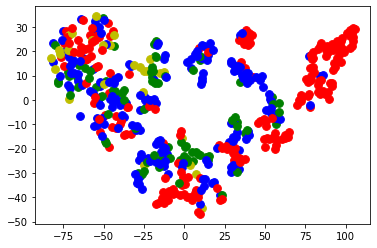

In [54]:
x, y = tSNE_map.T
colormap = ['r', 'b', 'g', 'y', 'm', 'k']

# labels = 

for i,label in enumerate(labels[0:1000]):
    plt.scatter(x[i],y[i], color=colormap[int(label)], s = 60)

Finally, repeat this exercise for different values of the perplexity. How does changing the perplexity change your 2D map?

What other - perhaps unstated - hyperparameter choice impacts your ability to do the class separation or interpret your 2D map? If this were a problem to come up in your research, how might you use your knowledge of the photometry and galaxy SEDs to improve the class separation in the 2D SNE plane?

## [Optional] Challenge Problem: Implementing your own SOM

(Very rough) pseudo code for a SOM implementation is provided below: 

$\textit{If you attempt this exercise, please provide feedback as this is intended as a problem for a future session.}$